# Document Clustering of News Articles

After setting up a new GitHub repository and creating a virtual environment, I first install all required modules into the environment.

In [63]:
!pip install pandas numpy scikit-learn matplotlib sentence-transformers

  Using cached sentence_transformers-2.1.0-py3-none-any.whl
  Using cached sentencepiece-0.1.96-cp39-cp39-win_amd64.whl (1.1 MB)


# Text inspection 

Let's load the required modules

In [177]:
import pandas as pd
import numpy as np

Let us load the texts and labels and get a first impression of the data.

In [178]:
texts = pd.read_csv('./preproc_texts.csv', header=None, names=['text'])
labels = pd.read_csv('./labels.csv', header=None, names=['label'])

In [179]:
df = texts.merge(labels, left_index=True, right_index=True)
df.sample(5)

,text,label
3,An innovative high school robotics team from M...,robotics_team_builds_wheelchair
10,Climate change is the greatest threat that we ...,climate_change_strike
32,Historian Camille Pascal told French broadcast...,fire_france_cathedral
17,falls deeper into the red after UK inflation s...,uk_inflation_data
20,World Europe France opens the question should ...,fire_france_cathedral


How does the length of the texts look like? Any outliers?

<AxesSubplot:ylabel='Frequency'>

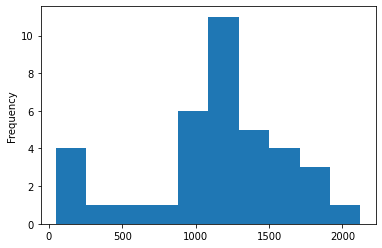

In [180]:
df.text.apply(len).plot(kind="hist")

There are some rather small news articles. Are they somehow special which is why we should treat them as "outliers" possibly removing from further analysis?

In [181]:
df.loc[df.text.apply(len)<500].style.set_properties(subset=['text'], **{'width': '900px'})

,text,label
10,Climate change is the greatest threat that we all face but it is the school kids of today whose futures are most on the line They are right to feel let down by the generation before them and it inspiring to see them making their voice heard today,climate_change_strike
12,Why did this happen Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading For more information you can review our Terms of Service and Cookie Policy,pollution_national_parks
14,What term do you want to search Search with google,uk_inflation_data
28,Researchers at Iowa State and Cornell universities looked at more than two decades of data on ozone pollution at parks from Shenandoah to Yellowstone the Grand Canyon and Yosemite They say visitor numbers dropped almost percent when ozone levels went up even slightly and by at least percent in months with three or more days of high ozone levels compared with months with fewer days of high ozone,pollution_national_parks
32,Historian Camille Pascal told French broadcaster BFMTV that invaluable heritage had been destroyed adding Happy and unfortunate events for centuries have been marked by the bells of Notre Dame We can be only horrified by what we see,fire_france_cathedral


Indeed, it looks like that the news text with indices **12** and **14** do not really represent news articles. To me, these observations should be disregarded in the cluster analysis.

In [182]:
df.drop(index=[12,14], inplace=True)

Let us take a quick look at the labels. The clusters are supposed to reflect the labels, so the number of labels gives us already the most important parameter one typically needs to decider over in cluster analysis: the **number of clusters (k)**.

<AxesSubplot:>

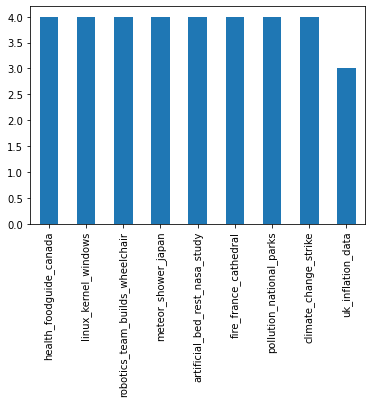

In [183]:
df.label.value_counts().plot(kind="bar")

There are **k = 9** distinct labels and the articles are equally distributed across labels.

In [175]:
k = 9

# Text clustering

A crucial step in text analysis is the question how to translate text into vectors, i.e. numerical representations of the text (or its tokens).
Depending on how the **vectorization** of the texts is conducted, I can think of two approaches how to solve the unsupervised clustering task:
- Bag of Words (BoW) approach + clustering
- Embedding approach using a pretrained transformer model + clustering


## Bag of Words approach + kMeans clustering

**Intuition**:<br>
In BoW, we assume that texts consist of a collection of words neglecting how the words are ordered and structured in the text. Typically, we simply count (and weigh) the occurrence of words in the text given a predefined vocabulary list. -> sparse, high dimensional vectors

**Advantage**:<br>
- intuitive and comparatively easy to communicate to stakeholders

**Disadvantage**:<br>
- important characteristics of human language neglected (word order, syntax, relationship between words, context)

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

First, we count the number of times a word occurs in a given news article and give the respective word a higher weight if it appears no too often across all documents.

In [200]:
sparse_vectors = TfidfVectorizer(
    analyzer = 'word',             # words as tokens
    lowercase = True,              # lowercase words
).fit_transform(df.text.values)
sparse_vectors

<35x1995 sparse matrix of type '<class 'numpy.float64'>'
	with 4435 stored elements in Compressed Sparse Row format>

This translates into high-dimensional (dimension equals the number vocabulary) vectors including many zeros (for tokens that do not appear in the respective article).

In [201]:
print(f"Document vectors have length {sparse_vectors.toarray()[1].shape[0]}: {sparse_vectors.toarray()[1]}")

Document vectors have length 1995: [0.06095117 0.         0.         ... 0.         0.         0.        ]


Now, we use the vectorized documents to form clusters. Let's us use kMeans clustering which is an intuitive and rather easy to communicate clustering approach: Assign documents to clusters such that deviation from the cluster center (from the "average document" within the cluster) is minimized.

In [176]:
clusters = KMeans(n_clusters=k, random_state=0).fit(sparse_vectors)

In [184]:
df['cluster'] = clusters.labels_

In [188]:
pd.pivot_table(df, index=['label'], columns=['cluster'], aggfunc=lambda x: str(len(x)), fill_value='')

text                        
cluster                            0  1  2  3  4  5  6  7  8
label                                                       
artificial_bed_rest_nasa_study                    4         
climate_change_strike                 4                     
fire_france_cathedral                 3                    1
health_foodguide_canada                              4      
linux_kernel_windows                        4               
meteor_shower_japan                4                        
pollution_national_parks                       4            
robotics_team_builds_wheelchair          4                  
uk_inflation_data                                       3

**Result**:<br>
Most of the clusters are "pure". This means that the articles with the same labels fall into the same cluster except for cluster **1**. Possibly, one could further improve the results using variants of the vectorization approach and the cluster algorithm.

## Embedding approach + kMeans clustering 

**Intuition**:<br>
In this second approach, we use the power of pre-trained transformer models. These are large (many parameters) neural networks with a complex architecture (bidirectional encoders) that are trained on massive amount of text corpora. Exploiting word co-occurence statistics found in these text corpora allows to represent words or a sequence of words (i.e. a text) as low-dimensional vectors (embeddings). Many of these pre-trained models are available to public for further fine-tuning or for "off-the-shelf" usage. We use them as input to our clustering algorithm.

**Advantage**:<br>
- vectors represent semantics or even "context" of the underlying text
- likely better clustering results

**Disadvantage**:<br>
- third party dependence (pre-training!)
- long range sequences require special consideration

In [204]:
from sentence_transformers import SentenceTransformer

Load the pretrained model and conduct the vectorization:

In [205]:
transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
dense_vectors = transformer.encode(df.text.apply(lambda x: x.lower()).reset_index(drop=True))

In [214]:
print(f"Document vectors have length {dense_vectors[1].shape[0]}: {dense_vectors[1][0:5]} ...")

Document vectors have length 384: [-0.06677002 -0.37917024 -0.10977136 -0.22782776 -0.21458885] ...


Note that only the 128 first tokens of the texts will be considered by the model.

In [223]:
transformer.max_seq_length

128

Also the tokenization approach is inherent to the model which is why we feed in the raw texts above.

In [227]:
transformer.tokenizer.tokenize('How are you today?')

['how', 'are', 'you', 'today', '?']

In [215]:
clusters = KMeans(n_clusters=k, random_state=0).fit(dense_vectors)

In [216]:
df['cluster'] = clusters.labels_

In [217]:
pd.pivot_table(df, index=['label'], columns=['cluster'], aggfunc=lambda x: str(len(x)), fill_value='')

text                        
cluster                            0  1  2  3  4  5  6  7  8
label                                                       
artificial_bed_rest_nasa_study        4                     
climate_change_strike                             4         
fire_france_cathedral              4                        
health_foodguide_canada                        4            
linux_kernel_windows                     4                  
meteor_shower_japan                                     4   
pollution_national_parks                                   4
robotics_team_builds_wheelchair             4               
uk_inflation_data                                    3

**Result**:<br> All of the clusters are "pure" for the embedding approach.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Happy to discuss the use case with you :)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~<br>

As text labels shall reflect the document cluster, we can think of this task as a (semi-)supervised scenario. Different model approaches exist for this purpose.

Let's start with a simple discriminative classification model which takes vectorized texts as feature inputs and text labels as targets. Unlike common classifiers whose performance is typically evaluated on a hold out test set, in a clustering task, the ultimate goal is to cluster (group) the *given* texts (no train-(eval)-test split necessary). 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Specifying a ML-pipeline to conveniently allow for hyper-parameter tuning.

In [39]:
pipeline = Pipeline([
    # Vectorization of texts
    ('vectorizer', TfidfVectorizer(
        analyzer='word',                   # words as tokens
        token_pattern='(?u)\\b\\w\\w+\\b', # default regex to split texts into word tokens
        lowercase=True                     # lowercase words before tokenization which has not been done as part of the pre-processing 
    )),
    # Classification model:
    # Unlike other classification models such SVMs or neural networks, the tree-based structure of a RF is easier to grasp
    # colleagues without quantitative background. It is important to communicate work to stakeholders!
    ('classifier', RandomForestClassifier(
        n_jobs=-1                          # run fitting of trees in parallel thereby efficiently using all our processing power
    ))
    ])

Define search spaces for those hyperparameters that shall be tuned in the subsequent random search.

In [51]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1),               # ignore words which appear in more than the given fraction of documents - typically they carry no signal to discriminate between classes
    'vectorizer__use_idf': (True, False),               # try both simple count vectorization and weighted count vectorization
    'classifier__n_estimators': (50, 100, 150),         # how many trees to train
    'classifier__min_samples_split': (2, 3, 4),         # minimum number of splits within a tree
    'classifier__min_samples_leaf': (1, 2, 3, 4),       # minimum number of observations in terminal leafs
}

In [49]:
search = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter=100,
    n_jobs=-1,
    cv = 2)

In [50]:
%%time
search.fit(df.text, df.label)

Wall time: 7.45 s


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__min_samples_leaf': (1, 2,
                                                                         3, 4),
                                        'classifier__min_samples_split': (2, 3,
                                                                          4),
                                        'classifier__n_estimators': (50, 100,
                                                                     150),
                                        'vectorizer__max_df': (0.5, 0.75, 1),
                                        'vectorizer__use_idf': (True, False)})

In [62]:
accurarcy = sum(search.predict(df.text)==df.label)/len(df)
accurarcy

1.0

Classes reflect clusters and classification model allows perfect clustering. But unlikely that classes are known and discriminative nature of model leads to overfitting!